Гопиенко Александр КИ22-17/2Б
Практическая работа №1 по глубокому обучению

In [43]:
import pandas as pd
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import f_classif, SelectKBest
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from scikeras.wrappers import KerasClassifier

# Задача классификации

Найдём пропущенные значения

In [44]:
df = pd.read_csv("telecom_churn.csv")
missing_values = df.isnull().sum()
print(missing_values)

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64


## Преобразуем категориальные признаки в числовые

In [45]:
df['Churn'] = df['Churn'].astype(int)
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = df.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(df[categorical_features])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([df, df_encoded], axis=1)
df.drop(categorical_features, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   int64  
 1   Area code               3333 non-null   int64  
 2   Number vmail messages   3333 non-null   int64  
 3   Total day minutes       3333 non-null   float64
 4   Total day calls         3333 non-null   int64  
 5   Total day charge        3333 non-null   float64
 6   Total eve minutes       3333 non-null   float64
 7   Total eve calls         3333 non-null   int64  
 8   Total eve charge        3333 non-null   float64
 9   Total night minutes     3333 non-null   float64
 10  Total night calls       3333 non-null   int64  
 11  Total night charge      3333 non-null   float64
 12  Total intl minutes      3333 non-null   float64
 13  Total intl calls        3333 non-null   int64  
 14  Total intl charge       3333 non-null   

## Удалим выбросы методом квантилей

In [46]:
column_to_check = df.iloc[:, :16]
df_res = df.iloc[:, 16:]
Q1 = column_to_check.quantile(0.25)
Q3 = column_to_check.quantile(0.75)

# Рассчитываем межквартильный размах (IQR)
IQR = Q3 - Q1

# Определяем границы для определения выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Фильтруем строки, удаляя выбросы
column_to_check = column_to_check[(column_to_check >= lower_bound) & (column_to_check <= upper_bound)]
df = pd.concat([column_to_check, df_res], axis=1)

## Избавимся от образовавшихся пропусков
Для начала выполним нормализацию данных

In [47]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df = pd.DataFrame(df_filled, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 69 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   float64
 1   Area code               3333 non-null   float64
 2   Number vmail messages   3333 non-null   float64
 3   Total day minutes       3333 non-null   float64
 4   Total day calls         3333 non-null   float64
 5   Total day charge        3333 non-null   float64
 6   Total eve minutes       3333 non-null   float64
 7   Total eve calls         3333 non-null   float64
 8   Total eve charge        3333 non-null   float64
 9   Total night minutes     3333 non-null   float64
 10  Total night calls       3333 non-null   float64
 11  Total night charge      3333 non-null   float64
 12  Total intl minutes      3333 non-null   float64
 13  Total intl calls        3333 non-null   float64
 14  Total intl charge       3333 non-null   

## Выполним стандартизацию данных

In [48]:
columns_except_one = [col for col in df.columns if col != 'Churn']
X = df[columns_except_one]
y = df['Churn']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df = pd.DataFrame(scaled_data, columns=X.columns)
df = pd.concat([df, y], axis=1)
columns_except_one = [col for col in df.columns if col != 'Churn']
X = df[columns_except_one]
y = df['Churn']

## Выберем наиболее важные признаки

In [49]:
selector = SelectKBest(score_func=f_classif, k=30)
X = selector.fit_transform(X, y)

## Определим на графике сбалансированность данных

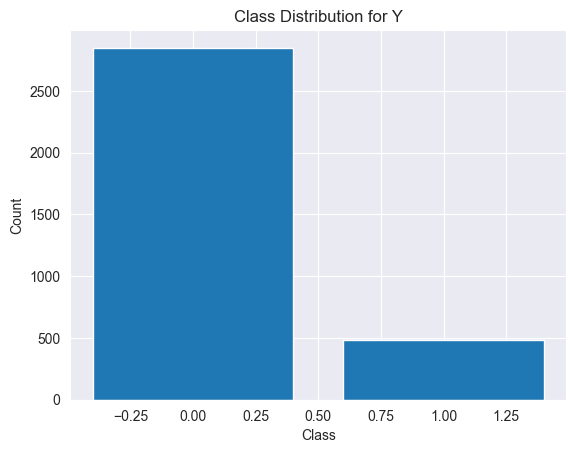

In [50]:
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
plt.bar(counter.keys(), counter.values())
plt.title("Class Distribution for Y")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## На графике виден недостаток данных

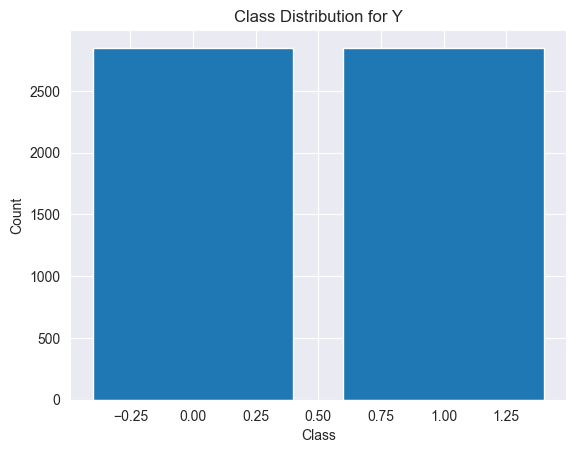

In [51]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
plt.bar(counter.keys(), counter.values())
plt.title("Class Distribution for Y")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Обучим нейронную сеть

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание базовой архитектуры нейронной сети
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) 

# Обучение модели
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', restore_best_weights=True)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks = [callback])


y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Оценка качества базовой модели на тестовой выборке
accuracy_base = accuracy_score(y_test, y_pred_binary)
print("Accuracy базовой модели:", accuracy_base)

Epoch 1/10
143/143 [==============================] - 3s 5ms/step - loss: 0.5890 - accuracy: 0.6853
Epoch 2/10
143/143 [==============================] - 1s 5ms/step - loss: 0.4928 - accuracy: 0.7607
Epoch 3/10
143/143 [==============================] - 1s 6ms/step - loss: 0.4505 - accuracy: 0.7794
Epoch 4/10
143/143 [==============================] - 1s 6ms/step - loss: 0.4224 - accuracy: 0.7950
Epoch 5/10
143/143 [==============================] - 1s 4ms/step - loss: 0.3987 - accuracy: 0.8118
Epoch 6/10
143/143 [==============================] - 1s 7ms/step - loss: 0.3830 - accuracy: 0.8154
Epoch 7/10
143/143 [==============================] - 1s 6ms/step - loss: 0.3692 - accuracy: 0.8270
Epoch 8/10
143/143 [==============================] - 1s 6ms/step - loss: 0.3524 - accuracy: 0.8362
Epoch 9/10
143/143 [==============================] - 1s 4ms/step - loss: 0.3427 - accuracy: 0.8436
Epoch 10/10
36/36 [==============================] - 0s 11ms/step
Accuracy базовой модели: 0.8149122

Выполним подбор параметров для нейронной сети

In [53]:
# Функция для создания модели нейронной сети
def build_clf(batch_size=32, epochs=100):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', restore_best_weights=True)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks = [callback])
    return model

# Создание экземпляра модели для использования в GridSearchCV
model = KerasClassifier(build_fn=build_clf)

# Определение сетки гиперпараметров для поиска
param_grid={'batch_size':[20, 30],  
        'epochs':[100, 200]
} 
# Создание стратифицированной k-fold кросс-валидации
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполнение поиска по сетке гиперпараметров
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, verbose=2)
grid_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
print("Наилучшие гиперпараметры:", grid_search.best_params_)
print()

# Оценка качества модели с лучшими параметрами на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Точность на тестовой выборке (с лучшими гиперпараметрами):", accuracy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1974 - accuracy: 0.9213
Epoch 2/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1893 - accuracy: 0.9189
Epoch 3/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1888 - accuracy: 0.9235
Epoch 4/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1785 - accuracy: 0.9293
Epoch 5/100
183/183 [==============================] - 1s 5ms/step - loss: 0.1771 - accuracy: 0.9268
Epoch 6/100
183/183 [==============================] - 1s 5ms/step - loss: 0.1690 - accuracy: 0.9345
Epoch 7/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1620 - accuracy: 0.9359
Epoch 8/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1595 - accuracy: 0.9389
Epoch 9/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1563 - accuracy: 0.9389
Epoch 10/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1477 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2251 - accuracy: 0.9079
Epoch 2/100
183/183 [==============================] - 3s 17ms/step - loss: 0.2162 - accuracy: 0.9065
Epoch 3/100
183/183 [==============================] - 2s 9ms/step - loss: 0.2109 - accuracy: 0.9131
Epoch 4/100
183/183 [==============================] - 1s 8ms/step - loss: 0.1976 - accuracy: 0.9211
Epoch 5/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1934 - accuracy: 0.9224
Epoch 6/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1912 - accuracy: 0.9257
Epoch 7/100
183/183 [==============================] - 1s 8ms/step - loss: 0.1838 - accuracy: 0.9304
Epoch 8/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1758 - accuracy: 0.9348
Epoch 9/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1738 - accuracy: 0.9372
Epoch 10/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1646 - accur

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
183/183 [==============================] - 1s 7ms/step - loss: 0.3016 - accuracy: 0.8690
Epoch 2/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2933 - accuracy: 0.8755
Epoch 3/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2847 - accuracy: 0.8810
Epoch 4/100
183/183 [==============================] - 1s 5ms/step - loss: 0.2681 - accuracy: 0.8871
Epoch 5/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2586 - accuracy: 0.8942
Epoch 6/100
183/183 [==============================] - 1s 8ms/step - loss: 0.2513 - accuracy: 0.8942
Epoch 7/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2436 - accuracy: 0.9024
Epoch 8/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2356 - accuracy: 0.9046
Epoch 9/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2283 - accuracy: 0.9046
Epoch 10/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2199 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
183/183 [==============================] - 0s 2ms/step - loss: 0.2232 - accuracy: 0.9062
Epoch 2/100
183/183 [==============================] - 1s 4ms/step - loss: 0.2147 - accuracy: 0.9079
Epoch 3/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2027 - accuracy: 0.9211
Epoch 4/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1946 - accuracy: 0.9224
Epoch 5/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1907 - accuracy: 0.9276
Epoch 6/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1820 - accuracy: 0.9304
Epoch 7/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1777 - accuracy: 0.9337
Epoch 8/100
183/183 [==============================] - 1s 6ms/step - loss: 0.1696 - accuracy: 0.9353
Epoch 9/100
183/183 [==============================] - 1s 5ms/step - loss: 0.1690 - accuracy: 0.9361
Epoch 10/100
183/183 [==============================] - 1s 7ms/step - loss: 0.1641 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2896 - accuracy: 0.8723
Epoch 2/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2813 - accuracy: 0.8808
Epoch 3/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2668 - accuracy: 0.8920
Epoch 4/100
183/183 [==============================] - 1s 5ms/step - loss: 0.2601 - accuracy: 0.8923
Epoch 5/100
183/183 [==============================] - 1s 3ms/step - loss: 0.2531 - accuracy: 0.8936
Epoch 6/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2433 - accuracy: 0.8997
Epoch 7/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2381 - accuracy: 0.9013
Epoch 8/100
183/183 [==============================] - 1s 5ms/step - loss: 0.2289 - accuracy: 0.9098
Epoch 9/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2236 - accuracy: 0.9084
Epoch 10/100
183/183 [==============================] - 1s 6ms/step - loss: 0.2176 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2019 - accuracy: 0.9178
Epoch 2/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1900 - accuracy: 0.9301
Epoch 3/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1864 - accuracy: 0.9268
Epoch 4/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1779 - accuracy: 0.9279
Epoch 5/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1756 - accuracy: 0.9315
Epoch 6/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1702 - accuracy: 0.9323
Epoch 7/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1654 - accuracy: 0.9400
Epoch 8/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1654 - accuracy: 0.9386
Epoch 9/200
183/183 [==============================] - 1s 5ms/step - loss: 0.1559 - accuracy: 0.9400
Epoch 10/200
183/183 [==============================] - 1s 5ms/step - loss: 0.1493 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2359 - accuracy: 0.9030
Epoch 2/200
183/183 [==============================] - 1s 8ms/step - loss: 0.2263 - accuracy: 0.9052
Epoch 3/200
183/183 [==============================] - 2s 9ms/step - loss: 0.2147 - accuracy: 0.9123
Epoch 4/200
183/183 [==============================] - 2s 8ms/step - loss: 0.2094 - accuracy: 0.9153
Epoch 5/200
183/183 [==============================] - 1s 7ms/step - loss: 0.2021 - accuracy: 0.9216
Epoch 6/200
183/183 [==============================] - 1s 8ms/step - loss: 0.1969 - accuracy: 0.9213
Epoch 7/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1887 - accuracy: 0.9298
Epoch 8/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1812 - accuracy: 0.9323
Epoch 9/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1766 - accuracy: 0.9353
Epoch 10/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1744 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2291 - accuracy: 0.9054
Epoch 2/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2255 - accuracy: 0.9038
Epoch 3/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2132 - accuracy: 0.9142
Epoch 4/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2034 - accuracy: 0.9213
Epoch 5/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2006 - accuracy: 0.9200
Epoch 6/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1934 - accuracy: 0.9249
Epoch 7/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1886 - accuracy: 0.9238
Epoch 8/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1817 - accuracy: 0.9298
Epoch 9/200
183/183 [==============================] - 1s 8ms/step - loss: 0.1756 - accuracy: 0.9334
Epoch 10/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1729 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2325 - accuracy: 0.9035
Epoch 2/200
183/183 [==============================] - 1s 7ms/step - loss: 0.2241 - accuracy: 0.9038
Epoch 3/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2128 - accuracy: 0.9095
Epoch 4/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2100 - accuracy: 0.9117
Epoch 5/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1971 - accuracy: 0.9224
Epoch 6/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1938 - accuracy: 0.9211
Epoch 7/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1899 - accuracy: 0.9230
Epoch 8/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1827 - accuracy: 0.9296
Epoch 9/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1762 - accuracy: 0.9328
Epoch 10/200
183/183 [==============================] - 1s 5ms/step - loss: 0.1741 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
183/183 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9298
Epoch 2/200
183/183 [==============================] - 2s 10ms/step - loss: 0.1682 - accuracy: 0.9375
Epoch 3/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1627 - accuracy: 0.9402
Epoch 4/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1555 - accuracy: 0.9424
Epoch 5/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1521 - accuracy: 0.9400
Epoch 6/200
183/183 [==============================] - 1s 5ms/step - loss: 0.1496 - accuracy: 0.9416
Epoch 7/200
183/183 [==============================] - 1s 5ms/step - loss: 0.1450 - accuracy: 0.9482
Epoch 8/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1392 - accuracy: 0.9474
Epoch 9/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1340 - accuracy: 0.9531
Epoch 10/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1338 - accur

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1941 - accuracy: 0.9252
Epoch 2/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1895 - accuracy: 0.9221
Epoch 3/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1828 - accuracy: 0.9312
Epoch 4/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1799 - accuracy: 0.9315
Epoch 5/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1742 - accuracy: 0.9326
Epoch 6/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1698 - accuracy: 0.9353
Epoch 7/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1663 - accuracy: 0.9364
Epoch 8/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1628 - accuracy: 0.9397
Epoch 9/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1555 - accuracy: 0.9378
Epoch 10/100
122/122 [==============================] - 1s 8ms/step - loss: 0.1533 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1953 - accuracy: 0.9301
Epoch 2/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1860 - accuracy: 0.9296
Epoch 3/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1806 - accuracy: 0.9342
Epoch 4/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1762 - accuracy: 0.9359
Epoch 5/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1716 - accuracy: 0.9383
Epoch 6/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1675 - accuracy: 0.9416
Epoch 7/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1644 - accuracy: 0.9413
Epoch 8/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1591 - accuracy: 0.9405
Epoch 9/100
122/122 [==============================] - 1s 8ms/step - loss: 0.1612 - accuracy: 0.9389
Epoch 10/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1554 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
122/122 [==============================] - 1s 6ms/step - loss: 0.2819 - accuracy: 0.8750
Epoch 2/100
122/122 [==============================] - 1s 4ms/step - loss: 0.2692 - accuracy: 0.8832
Epoch 3/100
122/122 [==============================] - 1s 7ms/step - loss: 0.2600 - accuracy: 0.8851
Epoch 4/100
122/122 [==============================] - 1s 6ms/step - loss: 0.2525 - accuracy: 0.8914
Epoch 5/100
122/122 [==============================] - 1s 4ms/step - loss: 0.2469 - accuracy: 0.8936
Epoch 6/100
122/122 [==============================] - 1s 7ms/step - loss: 0.2389 - accuracy: 0.9016
Epoch 7/100
122/122 [==============================] - 1s 5ms/step - loss: 0.2301 - accuracy: 0.9087
Epoch 8/100
122/122 [==============================] - 1s 5ms/step - loss: 0.2241 - accuracy: 0.9106
Epoch 9/100
122/122 [==============================] - 1s 6ms/step - loss: 0.2188 - accuracy: 0.9117
Epoch 10/100
122/122 [==============================] - 1s 4ms/step - loss: 0.2156 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
122/122 [==============================] - 0s 4ms/step - loss: 0.2135 - accuracy: 0.9126
Epoch 2/100
122/122 [==============================] - 1s 6ms/step - loss: 0.2113 - accuracy: 0.9115
Epoch 3/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1998 - accuracy: 0.9189
Epoch 4/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1959 - accuracy: 0.9208
Epoch 5/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1887 - accuracy: 0.9260
Epoch 6/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1859 - accuracy: 0.9263
Epoch 7/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1796 - accuracy: 0.9254
Epoch 8/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1756 - accuracy: 0.9317
Epoch 9/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1717 - accuracy: 0.9364
Epoch 10/100
122/122 [==============================] - 1s 5ms/step - loss: 0.1631 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1978 - accuracy: 0.9241
Epoch 2/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1937 - accuracy: 0.9252
Epoch 3/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1896 - accuracy: 0.9285
Epoch 4/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1808 - accuracy: 0.9296
Epoch 5/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1793 - accuracy: 0.9274
Epoch 6/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1743 - accuracy: 0.9353
Epoch 7/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1719 - accuracy: 0.9350
Epoch 8/100
122/122 [==============================] - 1s 4ms/step - loss: 0.1698 - accuracy: 0.9361
Epoch 9/100
122/122 [==============================] - 1s 6ms/step - loss: 0.1603 - accuracy: 0.9402
Epoch 10/100
122/122 [==============================] - 1s 7ms/step - loss: 0.1606 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2916 - accuracy: 0.8755
Epoch 2/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2813 - accuracy: 0.8766
Epoch 3/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2734 - accuracy: 0.8805
Epoch 4/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2638 - accuracy: 0.8862
Epoch 5/200
122/122 [==============================] - 1s 5ms/step - loss: 0.2558 - accuracy: 0.8923
Epoch 6/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2488 - accuracy: 0.9002
Epoch 7/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2403 - accuracy: 0.8980
Epoch 8/200
122/122 [==============================] - 1s 5ms/step - loss: 0.2336 - accuracy: 0.9013
Epoch 9/200
122/122 [==============================] - 1s 8ms/step - loss: 0.2280 - accuracy: 0.9090
Epoch 10/200
122/122 [==============================] - 1s 8ms/step - loss: 0.2218 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1851 - accuracy: 0.9287
Epoch 2/200
122/122 [==============================] - 0s 4ms/step - loss: 0.1827 - accuracy: 0.9301
Epoch 3/200
122/122 [==============================] - 1s 7ms/step - loss: 0.1725 - accuracy: 0.9345
Epoch 4/200
122/122 [==============================] - 1s 4ms/step - loss: 0.1688 - accuracy: 0.9364
Epoch 5/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1685 - accuracy: 0.9391
Epoch 6/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1626 - accuracy: 0.9400
Epoch 7/200
122/122 [==============================] - 0s 4ms/step - loss: 0.1558 - accuracy: 0.9454
Epoch 8/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1519 - accuracy: 0.9463
Epoch 9/200
122/122 [==============================] - 1s 4ms/step - loss: 0.1485 - accuracy: 0.9476
Epoch 10/200
122/122 [==============================] - 1s 7ms/step - loss: 0.1449 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2892 - accuracy: 0.8709
Epoch 2/200
122/122 [==============================] - 0s 4ms/step - loss: 0.2793 - accuracy: 0.8821
Epoch 3/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2713 - accuracy: 0.8884
Epoch 4/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2649 - accuracy: 0.8893
Epoch 5/200
122/122 [==============================] - 1s 5ms/step - loss: 0.2543 - accuracy: 0.8917
Epoch 6/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2490 - accuracy: 0.8931
Epoch 7/200
122/122 [==============================] - 0s 4ms/step - loss: 0.2427 - accuracy: 0.8980
Epoch 8/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2357 - accuracy: 0.9038
Epoch 9/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2295 - accuracy: 0.9046
Epoch 10/200
122/122 [==============================] - 1s 4ms/step - loss: 0.2224 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1997 - accuracy: 0.9202
Epoch 2/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1935 - accuracy: 0.9241
Epoch 3/200
122/122 [==============================] - 1s 4ms/step - loss: 0.1855 - accuracy: 0.9285
Epoch 4/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1824 - accuracy: 0.9304
Epoch 5/200
122/122 [==============================] - 0s 4ms/step - loss: 0.1750 - accuracy: 0.9356
Epoch 6/200
122/122 [==============================] - 1s 7ms/step - loss: 0.1731 - accuracy: 0.9348
Epoch 7/200
122/122 [==============================] - 0s 4ms/step - loss: 0.1687 - accuracy: 0.9337
Epoch 8/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1633 - accuracy: 0.9419
Epoch 9/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1614 - accuracy: 0.9397
Epoch 10/200
122/122 [==============================] - 0s 4ms/step - loss: 0.1567 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
122/122 [==============================] - 0s 4ms/step - loss: 0.2463 - accuracy: 0.8997
Epoch 2/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2412 - accuracy: 0.9005
Epoch 3/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2356 - accuracy: 0.9024
Epoch 4/200
122/122 [==============================] - 1s 5ms/step - loss: 0.2298 - accuracy: 0.9062
Epoch 5/200
122/122 [==============================] - 1s 7ms/step - loss: 0.2253 - accuracy: 0.9095
Epoch 6/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2192 - accuracy: 0.9079
Epoch 7/200
122/122 [==============================] - 1s 4ms/step - loss: 0.2163 - accuracy: 0.9120
Epoch 8/200
122/122 [==============================] - 1s 6ms/step - loss: 0.2069 - accuracy: 0.9169
Epoch 9/200
122/122 [==============================] - 0s 4ms/step - loss: 0.2079 - accuracy: 0.9147
Epoch 10/200
122/122 [==============================] - 1s 6ms/step - loss: 0.1992 - accura

C:\Users\sagop\venv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/200
152/152 [==============================] - 1s 6ms/step - loss: 0.2066 - accuracy: 0.9204
Epoch 2/200
152/152 [==============================] - 1s 6ms/step - loss: 0.2048 - accuracy: 0.9202
Epoch 3/200
152/152 [==============================] - 1s 4ms/step - loss: 0.1988 - accuracy: 0.9257
Epoch 4/200
152/152 [==============================] - 1s 6ms/step - loss: 0.1948 - accuracy: 0.9274
Epoch 5/200
152/152 [==============================] - 1s 6ms/step - loss: 0.1892 - accuracy: 0.9294
Epoch 6/200
152/152 [==============================] - 1s 6ms/step - loss: 0.1837 - accuracy: 0.9314
Epoch 7/200
152/152 [==============================] - 1s 5ms/step - loss: 0.1804 - accuracy: 0.9281
Epoch 8/200
152/152 [==============================] - 1s 6ms/step - loss: 0.1755 - accuracy: 0.9342
Epoch 9/200
152/152 [==============================] - 1s 5ms/step - loss: 0.1693 - accuracy: 0.9357
Epoch 10/200
152/152 [==============================] - 1s 4ms/step - loss: 0.1654 - accura

## Вывод: 
Нейронная сеть показывает гораздо лучшие результаты чем модели машинного обучения классификации